In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-04-25 03:15:09.818952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 03:15:09.922757: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 03:15:10.331275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-04-25 03:15:10.331326: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12286
12286
12286
12286
12286
12286
12286
12286


In [7]:
#############################
# ONLY peakS1_onlyhits DATA #
#############################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000


# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# close the h5 files
f_B.close()
f_S.close()
    
    
    

# X and Y for the classifier
X_mon = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_mon = scaler.fit_transform(X_mon)

del peakS1_onlyhits_B
del peakS1_onlyhits_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

max_pS1_both lenght:  168

X_mon_train :  (9999, 168)
y_mon_train :  (9999,)
X_mon_val :  (3334, 168)
y_mon_val :  (3334,)
X_mon_test :  (6667, 168)
y_mon_test :  (6667,)



### CLASSIFIER

[0]	validation_0-error:0.30883	validation_0-logloss:0.67610	validation_0-map:0.69619	validation_1-error:0.32573	validation_1-logloss:0.67815	validation_1-map:0.68035
[1]	validation_0-error:0.30053	validation_0-logloss:0.66185	validation_0-map:0.70194	validation_1-error:0.32274	validation_1-logloss:0.66562	validation_1-map:0.68861
[2]	validation_0-error:0.29973	validation_0-logloss:0.64989	validation_0-map:0.71108	validation_1-error:0.32214	validation_1-logloss:0.65580	validation_1-map:0.69054
[3]	validation_0-error:0.29703	validation_0-logloss:0.63982	validation_0-map:0.71324	validation_1-error:0.31314	validation_1-logloss:0.64731	validation_1-map:0.69256
[4]	validation_0-error:0.29563	validation_0-logloss:0.63113	validation_0-map:0.71938	validation_1-error:0.31854	validation_1-logloss:0.64127	validation_1-map:0.69028
[5]	validation_0-error:0.29463	validation_0-logloss:0.62331	validation_0-map:0.72320	validation_1-error:0.31374	validation_1-logloss:0.63527	validation_1-map:0.69204


/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.29463	validation_0-logloss:0.61658	validation_0-map:0.72596	validation_1-error:0.31314	validation_1-logloss:0.63024	validation_1-map:0.69180
[7]	validation_0-error:0.29373	validation_0-logloss:0.61082	validation_0-map:0.72729	validation_1-error:0.31314	validation_1-logloss:0.62579	validation_1-map:0.68976
[8]	validation_0-error:0.29193	validation_0-logloss:0.60559	validation_0-map:0.72693	validation_1-error:0.31284	validation_1-logloss:0.62259	validation_1-map:0.69497
[9]	validation_0-error:0.29183	validation_0-logloss:0.60098	validation_0-map:0.73142	validation_1-error:0.31314	validation_1-logloss:0.61972	validation_1-map:0.69378
[10]	validation_0-error:0.29143	validation_0-logloss:0.59710	validation_0-map:0.73728	validation_1-error:0.31194	validation_1-logloss:0.61782	validation_1-map:0.69168
[11]	validation_0-error:0.28823	validation_0-logloss:0.59300	validation_0-map:0.73817	validation_1-error:0.31314	validation_1-logloss:0.61583	validation_1-map:0.69150
[1

[56]	validation_0-error:0.25923	validation_0-logloss:0.53167	validation_0-map:0.80546	validation_1-error:0.31554	validation_1-logloss:0.61166	validation_1-map:0.68293
[57]	validation_0-error:0.25773	validation_0-logloss:0.53021	validation_0-map:0.80671	validation_1-error:0.31674	validation_1-logloss:0.61168	validation_1-map:0.68300


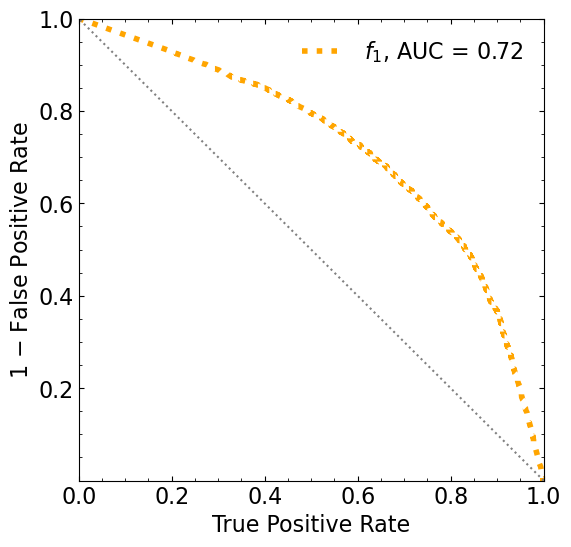

In [8]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric=["error", "logloss", "map"],early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

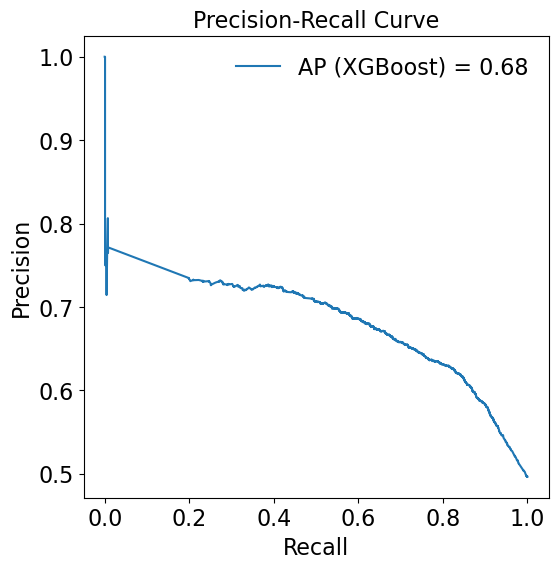

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_xg, recall_xg, _ = precision_recall_curve(y_mon_test, y_pred_xg)
auc_xg = auc(recall_xg, precision_xg)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_xg, precision_xg, label=f'AP (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

Accuracy: 66.93%


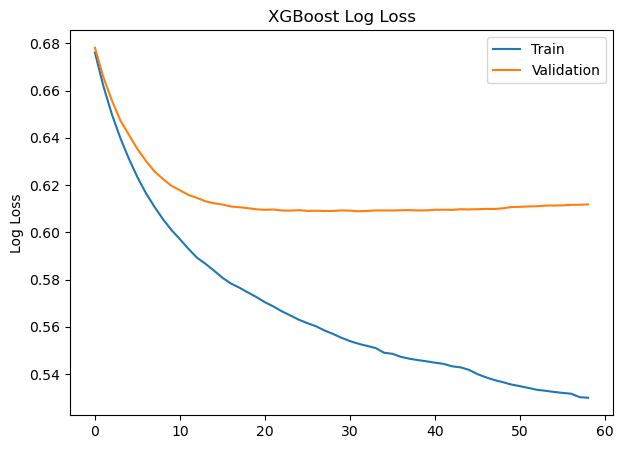

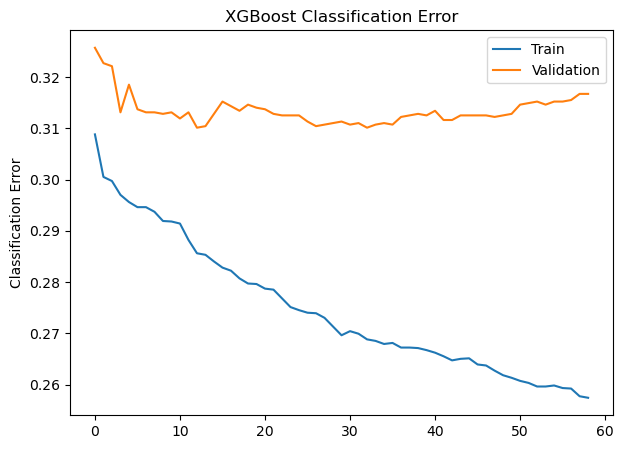

In [10]:
predictions = [round(value) for value in y_pred_xg]
accuracy = accuracy_score(y_mon_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# plot log loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Classification score:


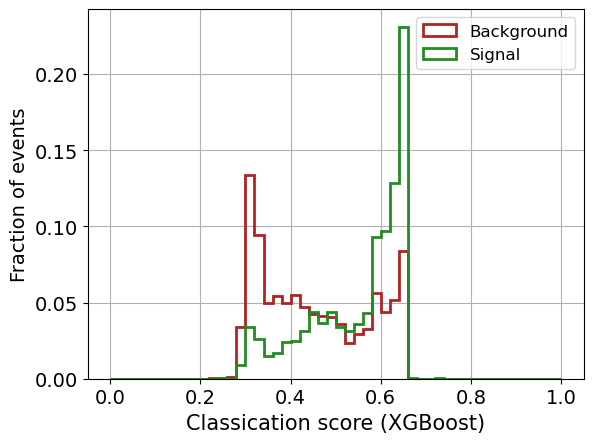

In [11]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()